In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict

In [2]:
HYPEROPTPATH = Path("/home/michaeldodds/Projects/manchester/computer_vision/results/hyperopt/")
RESULTPATH = HYPEROPTPATH / "final_iterative_exps.csv"
RESULTPATH_CNN = HYPEROPTPATH / "cnn_iterative_experiments3.csv"
df = pd.read_csv(RESULTPATH)
df_cnn = pd.read_csv(RESULTPATH_CNN)

In [3]:
df_cnn.columns.value_counts()

params             1
mean_test_score    1
std_test_score     1
dataset            1
norm_type          1
colour             1
classifier         1
Name: count, dtype: int64

In [36]:
params = list(df_cnn['params'])
param_dic = {i: eval(parms, {'OrderedDict' : OrderedDict}) for i, parms in enumerate(params)}
param_frame = pd.DataFrame(param_dic).T
param_frame.columns = [name.split("__", 1)[-1] for name in param_frame.columns.values]
param_frame.index = df_cnn.index
df_cnn = pd.concat([df_cnn, param_frame], axis=1)

In [41]:
cols = ['classifier', 'dataset', 'momentum', 'lr', 'epochs', 'batch_size', 'mean_test_score', 'std_test_score']
dfm = df_cnn[
    (df_cnn['classifier'] == 'split_cnn') &
    (df_cnn['dataset']    == 'mammals')
][cols]

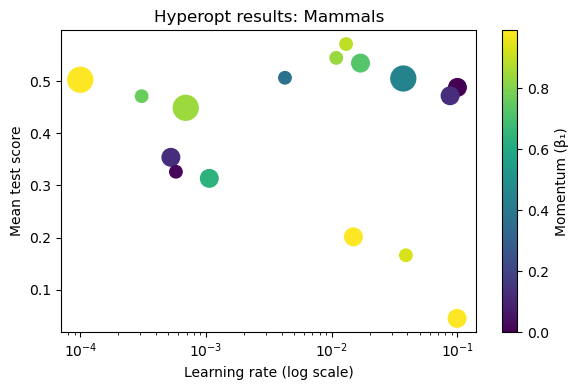

In [42]:
import matplotlib.pyplot as plt

# filter to one dataset:

# scatter mean score vs lr, color by momentum:
plt.figure(figsize=(6,4))
sc = plt.scatter(dfm['lr'], dfm['mean_test_score'],
                 s=dfm['batch_size']*20,          # bubble size ~ batch
                 c=dfm['momentum'],                # color ~ momentum
                 cmap='viridis')
plt.xscale('log')
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Mean test score")
plt.title("Hyperopt results: Mammals")
plt.colorbar(sc, label="Momentum (β₁)")
plt.tight_layout()
plt.show()


In [5]:
df_cnn['colour'] = df_cnn['colour'].fillna(3)
cols = ['dataset', 'norm_type', 'colour', 'classifier']
idx = df_cnn.groupby(cols)['mean_test_score'].idxmax()
cnn_aggregated_results = df_cnn.groupby(cols).aggregate({'mean_test_score':['max']})
best_rows = df_cnn.loc[idx].sort_values('mean_test_score', ascending=False)
cnn_aggregated_results

mean_test_score
                                                    max
dataset norm_type colour    classifier                 
mammals 32        greyscale classic_cnn        0.222155
                  rgb       classic_cnn        0.293398
                            split_cnn          0.571142
stl10   32        greyscale classic_cnn        0.471008
                  rgb       classic_cnn        0.478202
                            split_cnn          0.645196

In [6]:
params = list(best_rows['params'])
param_dic = {i: eval(parms, {'OrderedDict' : OrderedDict}) for i, parms in enumerate(params)}
param_frame = pd.DataFrame(param_dic).T
param_frame.columns = [name.split("__", 1)[-1] for name in param_frame.columns.values]
param_frame.index = best_rows.index
best_rows_with_params = pd.concat([best_rows, param_frame], axis=1)

In [26]:
best_rows_with_params[best_rows_with_params['dataset'] == 'mammals']['momentum']


0     0.891627
16    0.729315
32    0.494624
Name: momentum, dtype: float64

In [7]:
cols = ['dataset', 'classifier', 'keypoints_algo', 'descriptor_algo']
idx = df.groupby(cols)['mean_test_score'].idxmax()
aggregated_results = df.groupby(cols).aggregate({'mean_test_score':['max']})
best_rows = df.loc[idx].sort_values('mean_test_score', ascending=False)
aggregated_results

mean_test_score
                                                              max
dataset classifier keypoints_algo descriptor_algo                
mammals knn        dense          dense_hist             0.202993
                                  sift                   0.171493
                   none           none                   0.135997
                   sift           dense_hist             0.185987
                                  sift                   0.147499
        rf         dense          dense_hist             0.219991
                                  sift                   0.188001
                   none           none                   0.196002
                   sift           dense_hist             0.201488
                                  sift                   0.172998
stl10   knn        dense          dense_hist             0.288043
                                  sift                   0.353003
                   none           none                   0.279966
                   sift           dense_hist             0.241987
                                  sift                   0.265014
        rf         dense          dense_hist             0.339004
                                  sift                   0.409032
                   none           none                   0.338000
                   sift           dense_hist             0.292020
                                  sift                   0.314018

In [8]:
aggregated_results_outpath = Path(HYPEROPTPATH, 'aggregated_results')
cv_agg_results_outpath = aggregated_results_outpath / 'cv_aggregated_results.csv'
cv_results_outpath = aggregated_results_outpath / 'cv_best_classifiers.csv'

cnn_agg_results_outpath = aggregated_results_outpath / 'cnn_aggregated_results.csv'
cnn_results_outpath = aggregated_results_outpath / 'cnn_best_classifiers.csv'

aggregated_results_outpath.mkdir(parents=True, exist_ok=True)

aggregated_results.to_csv(cv_results_outpath, index=True)
best_rows.to_csv(cv_results_outpath, index=False)

cnn_aggregated_results.to_csv(cnn_agg_results_outpath, index=True)
best_rows_with_params.to_csv(cnn_results_outpath, index=False)

In [9]:
zero = best_rows_with_params.iloc[0]
one = best_rows_with_params.iloc[1]

In [10]:
pd.concat([zero, one], axis=1).T

,params,mean_test_score,std_test_score,dataset,norm_type,colour,classifier,batch_size,epochs,channels,class_heads,kernel_width,lr,momentum
48,"OrderedDict({'batch_size': 4, 'epochs': 24, 'n...",0.645196,0.036004,stl10,32,rgb,split_cnn,4.0,24.0,3.0,10.0,7.0,0.010868,0.837506
0,"OrderedDict({'batch_size': 4, 'epochs': 25, 'n...",0.571142,0.009148,mammals,32,rgb,split_cnn,4.0,25.0,3.0,20.0,7.0,0.013012,0.891627
